# Dog Breeds Image Classification

In this notebook, we will use [dog breed images](http://vision.stanford.edu/aditya86/ImageNetDogs/) and use transfer learning to identify the dog breed. The hyperparameter tuning and model training are done using Sagemaker training job.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
INSTALL_PACKAGES = True
if INSTALL_PACKAGES:
    !pip install smdebug
    !pip install tqdm

In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import numpy as np
import seaborn as sns

sns.set_context("talk")

BUCKET = 'project03-image-classification-vexenta'

## Dataset

*TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.*

The dataset contains images of 133 dog breeds, which are already split into train, validation, and test sets.

In [5]:
# TODO: Fetch and upload the data to AWS S3
DOWNLOAD_DATASET = False
if DOWNLOAD_DATASET:
    # Command to download and unzip data
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip
    
UPLOAD_TO_S3 = False
os.environ["DEFAULT_S3_BUCKET"] = BUCKET

if UPLOAD_TO_S3:
    !aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/data/train/
    !aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/data/valid/
    !aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/data/test/

There are 133 dog breeds; each dog breed image is stored in a directory. There are at least 20 images per breed.

In [6]:
## ensure the files are successfully uploaded
CHECK_UPLOAD = True
if CHECK_UPLOAD:
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/  | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/valid/ | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/test/ | wc -l
        
    ## preview of the breeds
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/ | tail -n 10

133
133
133
                           PRE 124.Poodle/
                           PRE 125.Portuguese_water_dog/
                           PRE 126.Saint_bernard/
                           PRE 127.Silky_terrier/
                           PRE 128.Smooth_fox_terrier/
                           PRE 129.Tibetan_mastiff/
                           PRE 130.Welsh_springer_spaniel/
                           PRE 131.Wirehaired_pointing_griffon/
                           PRE 132.Xoloitzcuintli/
                           PRE 133.Yorkshire_terrier/


### Dataset Preview

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_image(image_file_directory: str = None, image_file_path: str = None):
    if image_file_path is None:
        assert image_file_directory is not None, "image_file_directory must be specified if image_file_path is None!"
        image_file_name_list = os.listdir(image_file_directory)
        selected_image_index = np.random.choice(len(image_file_name_list))
        selected_image_file_name = image_file_name_list[selected_image_index]
        image_file_path = os.path.join(
            image_file_directory,
            selected_image_file_name
        )
    else:
        selected_image_file_name = image_file_path.split("/")[-1]
    
    img = mpimg.imread(image_file_path)
    img_plot = plt.imshow(img)
    plt.title(selected_image_file_name)
    plt.show()

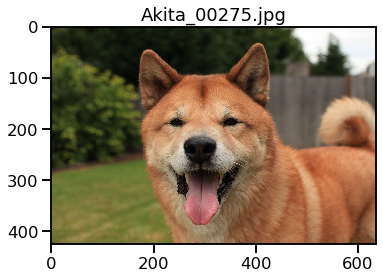

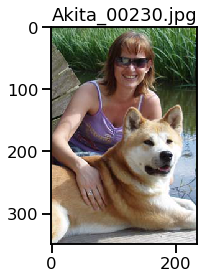

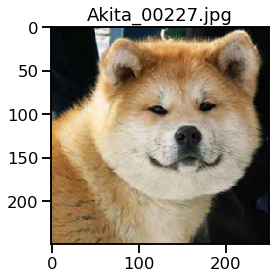

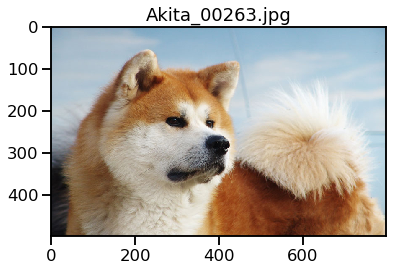

In [8]:
show_image(image_file_directory="dogImages/train/004.Akita")
show_image(image_file_path="dogImages/train/004.Akita/Akita_00230.jpg")

show_image(image_file_directory="dogImages/valid/004.Akita")
show_image(image_file_directory="dogImages/test/004.Akita")

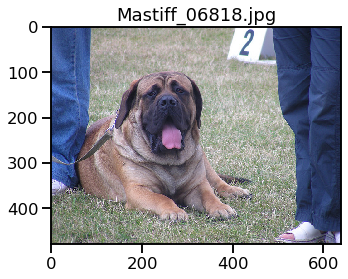

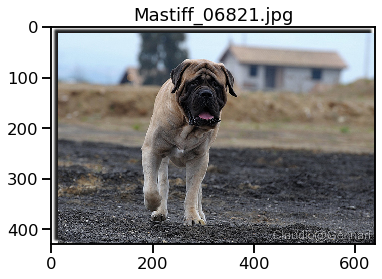

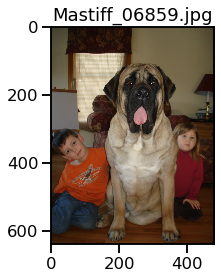

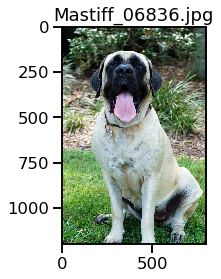

In [9]:
show_image(image_file_directory="dogImages/train/103.Mastiff")
show_image(image_file_path="dogImages/train/103.Mastiff/Mastiff_06821.jpg")

show_image(image_file_directory="dogImages/valid/103.Mastiff")
show_image(image_file_directory="dogImages/test/103.Mastiff")

In [10]:
import pandas as pd
from tqdm import tqdm

def extract_dataset_metadata(dataset_directory: str) -> pd.DataFrame:
    """
    Extract target class, file name, and full file path of the provided dataset directory

    :param dataset_directory: directory where the data are stored
    :type dataset_directory: str
    :return: dataframe that contains metadata: target class, file name, and full file path
    :rtype: pd.DataFrame
    """
    meta = list()
    for directory_name, _, file_names in tqdm(os.walk(dataset_directory)):
        for file_name in file_names:
            class_name = directory_name.split('/')[-1]
            full_path = os.path.join(directory_name, file_name)
            meta.append([
                class_name,
                file_name,
                full_path
            ])
    
    return pd.DataFrame(
        meta, 
        columns=['target_class', 'file_name', 'full_path']
    )

In [11]:
df_meta_train = extract_dataset_metadata(dataset_directory="dogImages/train/")
df_meta_valid = extract_dataset_metadata(dataset_directory="dogImages/valid/")
df_meta_test = extract_dataset_metadata(dataset_directory="dogImages/test/")

134it [00:01, 104.91it/s]
134it [00:00, 145.44it/s]
134it [00:00, 149.06it/s]


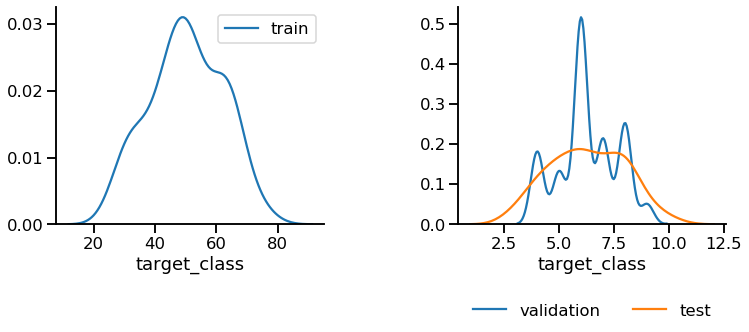

In [24]:
## plot distribution of target class counts in train, validation, test set
f, ax = plt.subplots(figsize=(12,4), ncols=2)
plt.subplots_adjust(wspace=.5)
sns.distplot(
    df_meta_train["target_class"].value_counts(),
    hist=False,
    label='train',
    ax=ax[0]
);

sns.distplot(
    df_meta_valid["target_class"].value_counts(),
    hist=False,
    label='validation',
    ax=ax[1]
);

sns.distplot(
    df_meta_test["target_class"].value_counts(),
    hist=False,
    label='test',
    ax=ax[1]
);

plt.legend(loc='lower center', bbox_to_anchor=[.5,-.5], ncol=2, frameon=False)
sns.despine();

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a **minimum of two hyperparameters**. However you are encouraged to tune more. You are also encouraged to explain **why** you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [25]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()

In [26]:
model_output_dir = 's3://project03-image-classification-vexenta/model/hp-tuning/model.tar.gz'
input_train = f"s3://{BUCKET}/data/train/"
input_valid = f"s3://{BUCKET}/data/valid/"
input_test = f"s3://{BUCKET}/data/test/"

os.environ["SM_MODEL_DIR"] = model_output_dir
os.environ["SM_CHANNEL_TRAIN"] = input_train
os.environ["SM_CHANNEL_VALIDATION"] = input_valid
os.environ["SM_CHANNEL_TEST"] = input_test

In [27]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([128, 256]),
    "epochs": CategoricalParameter([5, 7, 10])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}] ## if using cross-entropy loss
# metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: -([0-9\\.]+)"}] ## if using NLLLoss

In [28]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="src/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c4.4xlarge",
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=2, 
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [18]:
# TODO: Fit your HP Tuner
tuner.fit(
    inputs={
        "train": input_train, 
        "validation": input_valid,
    },
    wait=True
) # TODO: Remember to include your data channels

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [19]:
tuner.best_training_job()

'pytorch-training-211204-2308-001-5c023cd1'

In [20]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-05 00:26:35 Starting - Preparing the instances for training
2021-12-05 00:26:35 Downloading - Downloading input data
2021-12-05 00:26:35 Training - Training image download completed. Training in progress.
2021-12-05 00:26:35 Uploading - Uploading generated training model
2021-12-05 00:26:35 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"7"',
 'lr': '0.0053945745752048664',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-04-23-08-46-531"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-04-23-08-46-531/source/sourcedir.tar.gz"'}

In [23]:
hyperparameters = best_estimator.hyperparameters()

hyperparameters

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"7"',
 'lr': '0.0053945745752048664',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-04-23-08-46-531"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-04-23-08-46-531/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [42]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    # hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
    collection_configs=collection_config_list
)

In [43]:
# ## from this training job: pytorch-training-2021-12-04-23-08-46-531
hyperparameters = {
    "lr": 0.0053945745752048664,
    "batch-size": 256,
    "epochs": 7,
}

## reformat input
for key in ["epochs","batch-size"]:
    if not isinstance(hyperparameters[key], int):
        hyperparameters[key] = int(hyperparameters[key].replace('"',''))

In [44]:
hyperparameters

{'lr': 0.0053945745752048664, 'batch-size': 256, 'epochs': 7}

In [50]:
# TODO: Create and fit an estimator
TRAIN_MODEL = False

if TRAIN_MODEL:
    estimator = PyTorch(
        entry_point="src/train_model.py",
        role=role,
        py_version='py36',
        framework_version="1.8",
        instance_count=1,
        instance_type="ml.c4.4xlarge",
        hyperparameters=hyperparameters,
        rules=rules,
        debugger_hook_config=hook_config,
        profiler_config=profiler_config,
    ) # TODO: Your estimator here

    estimator.fit(
        inputs={
            "train": input_train, 
    #         "validation": input_valid,
            "test": input_test,
        },
        wait=True
    )
else:
    ## if not re-training the model, just refer to the latest result
    ## TO DO: change to the latest one
    training_job_name = "pytorch-training-2021-12-06-07-50-12-692"
    algo_image = sagemaker.image_uris.retrieve(
        framework='pytorch',
        version="1.8",
        region=session.boto_region_name,
        py_version="py36",
        instance_type="ml.c4.4xlarge",
        image_scope="inference",
    )
    estimator = sagemaker.model.Model(
        image_uri=algo_image,
        model_data=f"s3://sagemaker-us-east-1-214854311692/{training_job_name}/output/model.tar.gz",
        role=role
    )

2021-12-06 07:50:13 Starting - Starting the training job...
2021-12-06 07:50:41 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2021-12-06 07:51:12 Starting - Preparing the instances for training.........
2021-12-06 07:52:42 Downloading - Downloading input data.........
2021-12-06 07:54:11 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-06 07:54:12,529 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-06 07:54:12,531 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-06 07:54:12,540 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-06 07:54:13,981 sa

In [53]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2021-12-06 09:13:21.541 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:23 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-06 09:13:21.565 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:23 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-06-07-50-12-692/debug-output
[2021-12-06 09:13:22.207 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:23 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 232 more expected)', IncompleteRead(0 bytes read, 232 more expected)) while reading s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-06-07-50-12-692/debug-output/index/000000000/000000000032_worker_0.json . Will retry now
[2021-12-06 09:13:25.019 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:23 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-06 09:13:26.044 datascience-1-

['CrossEntropyLoss_output_0']

In [58]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

19

In [59]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [60]:
steps_train, vals_train = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)
vals_train

[array(5.0460763, dtype=float32),
 array(1.7026348, dtype=float32),
 array(1.7694756, dtype=float32),
 array(1.0497842, dtype=float32),
 array(1.1590109, dtype=float32),
 array(1.4126852, dtype=float32),
 array(1.2338521, dtype=float32),
 array(1.3616244, dtype=float32),
 array(0.80958456, dtype=float32),
 array(1.116055, dtype=float32),
 array(1.1485533, dtype=float32),
 array(1.3429425, dtype=float32),
 array(1.2663715, dtype=float32),
 array(1.5747538, dtype=float32),
 array(1.369376, dtype=float32),
 array(1.3947204, dtype=float32),
 array(1.4657164, dtype=float32),
 array(1.353581, dtype=float32),
 array(1.6280429, dtype=float32)]

In [61]:
steps_eval, vals_eval = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)
vals_eval

[array(0.7034491, dtype=float32),
 array(0.6179562, dtype=float32),
 array(0.69539607, dtype=float32),
 array(0.7594285, dtype=float32),
 array(1.4835979, dtype=float32),
 array(0.6370825, dtype=float32),
 array(1.0038528, dtype=float32),
 array(0.58240604, dtype=float32),
 array(0.7065114, dtype=float32),
 array(0.80452716, dtype=float32),
 array(0.7424128, dtype=float32),
 array(0.91582924, dtype=float32),
 array(0.77241325, dtype=float32),
 array(0.16921763, dtype=float32),
 array(0.4021615, dtype=float32),
 array(1.050482, dtype=float32),
 array(0.48486978, dtype=float32),
 array(0.74061996, dtype=float32),
 array(0.56629723, dtype=float32),
 array(0.5272408, dtype=float32),
 array(0.4841543, dtype=float32),
 array(0.68732375, dtype=float32),
 array(0.9699249, dtype=float32),
 array(1.4008673, dtype=float32),
 array(0.62727875, dtype=float32),
 array(0.61126214, dtype=float32),
 array(0.8520888, dtype=float32),
 array(0.661648, dtype=float32),
 array(0.7168401, dtype=float32),
 arr

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


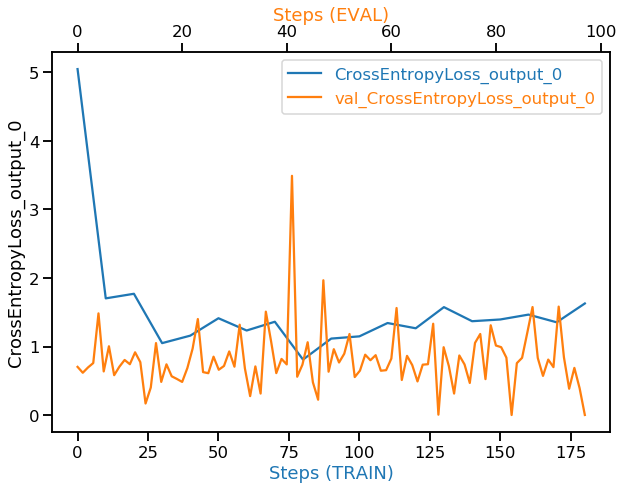

In [63]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

The validation loss is unstable and doesn't decrease as the model is trained with more iterations. It implies that the model might not perform well - we could consider revisiting our hyperparameter search range (e.g., reducing batch size, increasing epochs) and do more hyperparameter tuning. Alternatively, we might consider using different pretrained model.

In [64]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-06-07-50-12-692/rule-output
2021-12-06 09:07:51     374910 pytorch-training-2021-12-06-07-50-12-692/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-06 09:07:50     222814 pytorch-training-2021-12-06-07-50-12-692/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-06 09:07:45        192 pytorch-training-2021-12-06-07-50-12-692/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-06 09:07:45        200 pytorch-training-2021-12-06-07-50-12-692/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-06 09:07:45       2033 pytorch-training-2021-12-06-07-50-12-692/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-06 09:07:45        127 pytorch-training-2021-12-06-07-50-12-692/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

In [65]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [66]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

There are no major issues from the Profiling report. We didn't use GPU - that's why the utilization is low.

## Model Deploying

In [74]:
import sagemaker
import boto3

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [75]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [77]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances
model_location = "s3://sagemaker-us-east-1-214854311692/pytorch-training-2021-12-06-07-50-12-692/output/model.tar.gz" #estimator.model_data

pytorch_model = PyTorchModel(
    model_data=model_location, 
    role=role,
    entry_point='src/inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor
)

predictor = pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large'
)

ReadError: not a gzip file

In [ ]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ 
    "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" 
}

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

In [ ]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

response = predictor.predict(
    img_bytes, 
    initial_args={
        "ContentType": "image/jpeg"
    }
)

In [ ]:
import json

response2 = predictor.predict(
    json.dumps(request_dict), 
    initial_args={
        "ContentType": "application/json"
    }
)

In [ ]:
type(response2[0][0])

In [ ]:
response2[0]

In [ ]:
import torch
import numpy as np
np.argmax(response, 1)

In [72]:
# # TODO: Deploy your model to an endpoint
# # TODO: Add your deployment configuration like instance type and number of instances
# deployment = estimator.deploy(
#     initial_instance_count=1, 
#     instance_type="ml.m5.xlarge"
# )
# endpoint = deployment.endpoint_name

# predictor = sagemaker.predictor.Predictor(
#     endpoint,
#     sagemaker_session=sagemaker.Session(),
# )

In [ ]:
# import sagemaker 

# session = sagemaker.Session()
# role = sagemaker.get_execution_role()

# training_job_name = "pytorch-training-2021-12-06-07-50-12-692"
# algo_image = sagemaker.image_uris.retrieve(
#     framework='pytorch',
#     version="1.8",
#     region=session.boto_region_name,
#     py_version="py36",
#     instance_type="ml.t2.medium",
#     image_scope="inference",
# )
# model = sagemaker.model.Model(
#     image_uri=algo_image,
#     model_data=f"s3://sagemaker-us-east-1-214854311692/{training_job_name}/output/model.tar.gz",
#     role=role
# )

# predictor = model.deploy(
#     initial_instance_count=1, 
#     instance_type="ml.m5.xlarge"
# )

In [82]:
# TODO: Run an prediction on the endpoint

from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("dogImages/train/004.Akita/Akita_00230.jpg", "rb") as f:
    payload = f.read()
    
image = payload # TODO: Your code to load and preprocess image to send to endpoint for prediction
image
# response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()